<a href="https://colab.research.google.com/github/YueWangpl/covid_pred/blob/main/src/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# !pip install geopandas
# !pip install -U kaleido
# !pip install auto_ts --upgrade
# import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Data cleaning and EDA

In [2]:
# with renewal:
df = pd.read_csv('https://query.data.world/s/sxvlqlsumzqr5sp33p5crszmdl36r4')

## or from folder 'data/' if downloaded:
# df = pd.read_csv('../data/COVID-19 Activity.csv')

df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



(2439537, 13)

In [ ]:
# time series data
df.head()

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,0,Clay,Alabama,2020-01-22,America,New York Times,0,1027.0,USA,United States,US,0,0
1,0,Clay,Alabama,2020-01-23,America,New York Times,0,1027.0,USA,United States,US,0,0
2,0,Clay,Alabama,2020-01-24,America,New York Times,0,1027.0,USA,United States,US,0,0
3,0,Clay,Alabama,2020-01-25,America,New York Times,0,1027.0,USA,United States,US,0,0
4,0,Clay,Alabama,2020-01-26,America,New York Times,0,1027.0,USA,United States,US,0,0


In [ ]:
len(df['COUNTRY_ALPHA_3_CODE'].unique())

219

In [ ]:
df[['DATA_SOURCE_NAME']].value_counts()

DATA_SOURCE_NAME          
New York Times                2063250
JHU CSSE Global Timeseries     173250
dtype: int64

In [ ]:
len(df[df['DATA_SOURCE_NAME']=='New York Times']['COUNTY_NAME'].unique())

1930

In [ ]:
sorted(df['REPORT_DATE'].unique())[-5:-1]

['2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09']

Use data only in the US

In [3]:
df_us = df[df['COUNTRY_ALPHA_3_CODE']=="USA"]
df_us

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,0,Clay,Alabama,2020-01-22,America,New York Times,0,1027.0,USA,United States,US,0,0
1,0,Clay,Alabama,2020-01-23,America,New York Times,0,1027.0,USA,United States,US,0,0
2,0,Clay,Alabama,2020-01-24,America,New York Times,0,1027.0,USA,United States,US,0,0
3,0,Clay,Alabama,2020-01-25,America,New York Times,0,1027.0,USA,United States,US,0,0
4,0,Clay,Alabama,2020-01-26,America,New York Times,0,1027.0,USA,United States,US,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425704,5406,Teton,Wyoming,2021-12-03,America,New York Times,0,56039.0,USA,United States,US,8,14
2425705,5406,Teton,Wyoming,2021-12-04,America,New York Times,0,56039.0,USA,United States,US,0,14
2425706,5406,Teton,Wyoming,2021-12-05,America,New York Times,0,56039.0,USA,United States,US,0,14
2425707,5417,Teton,Wyoming,2021-12-06,America,New York Times,0,56039.0,USA,United States,US,11,14


In [4]:
df_us['REPORT_DATE'] =  pd.to_datetime(df_us['REPORT_DATE'])
df_us.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PEOPLE_POSITIVE_CASES_COUNT                 int64
COUNTY_NAME                                object
PROVINCE_STATE_NAME                        object
REPORT_DATE                        datetime64[ns]
CONTINENT_NAME                             object
DATA_SOURCE_NAME                           object
PEOPLE_DEATH_NEW_COUNT                      int64
COUNTY_FIPS_NUMBER                        float64
COUNTRY_ALPHA_3_CODE                       object
COUNTRY_SHORT_NAME                         object
COUNTRY_ALPHA_2_CODE                       object
PEOPLE_POSITIVE_NEW_CASES_COUNT             int64
PEOPLE_DEATH_COUNT                          int64
dtype: object

In [ ]:
df_us['PEOPLE_POSITIVE_NEW_CASES_COUNT'].describe()

count    2.008440e+06
mean     2.201349e+01
std      2.821782e+02
min     -1.239550e+05
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+01
max      5.661000e+04
Name: PEOPLE_POSITIVE_NEW_CASES_COUNT, dtype: float64

In [ ]:
df_us[df_us['PEOPLE_POSITIVE_NEW_CASES_COUNT'] < 0]

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
12,126,Taylor,Wisconsin,2020-09-08,America,New York Times,0,55119.0,USA,United States,US,-3,3
177,2139,Taylor,Wisconsin,2021-07-02,America,New York Times,0,55119.0,USA,United States,US,-1,38
188,76,Taylor,Wisconsin,2020-08-15,America,New York Times,1,55119.0,USA,United States,US,-1,2
305,24,Clarke,Alabama,2020-04-24,America,New York Times,0,1025.0,USA,United States,US,-1,1
320,52,Clarke,Alabama,2020-05-09,America,New York Times,0,1025.0,USA,United States,US,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424989,1180,Red Willow,Nebraska,2021-03-09,America,New York Times,0,31145.0,USA,United States,US,-1,12
2425025,1188,Red Willow,Nebraska,2021-03-24,America,New York Times,1,31145.0,USA,United States,US,-1,13
2425043,1206,Red Willow,Nebraska,2021-04-28,America,New York Times,0,31145.0,USA,United States,US,-1,15
2425176,1209,Red Willow,Nebraska,2021-05-13,America,New York Times,0,31145.0,USA,United States,US,-1,15


In [5]:
df_USdaily = df_us[['REPORT_DATE','PEOPLE_POSITIVE_NEW_CASES_COUNT']].groupby(by='REPORT_DATE').agg('sum').reset_index()
df_USdaily

,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,1
...,...,...
682,2021-12-03,153024
683,2021-12-04,57985
684,2021-12-05,34417
685,2021-12-06,197258


In [ ]:
df_USdaily[df_USdaily['PEOPLE_POSITIVE_NEW_CASES_COUNT'] < 0]

,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT
500,2021-06-04,-24084


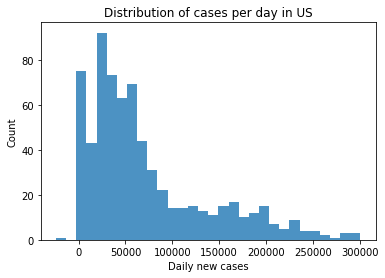

In [7]:
df_USdaily['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot.hist(bins = int(np.sqrt(df_us.shape[0])/48), alpha=0.8)  
plt.ylabel('Count')
# plt.semilogx()
plt.xlabel('Daily new cases')
plt.title('Distribution of cases per day in US')
plt.savefig('../figures/USdailyhist.png')
plt.show()

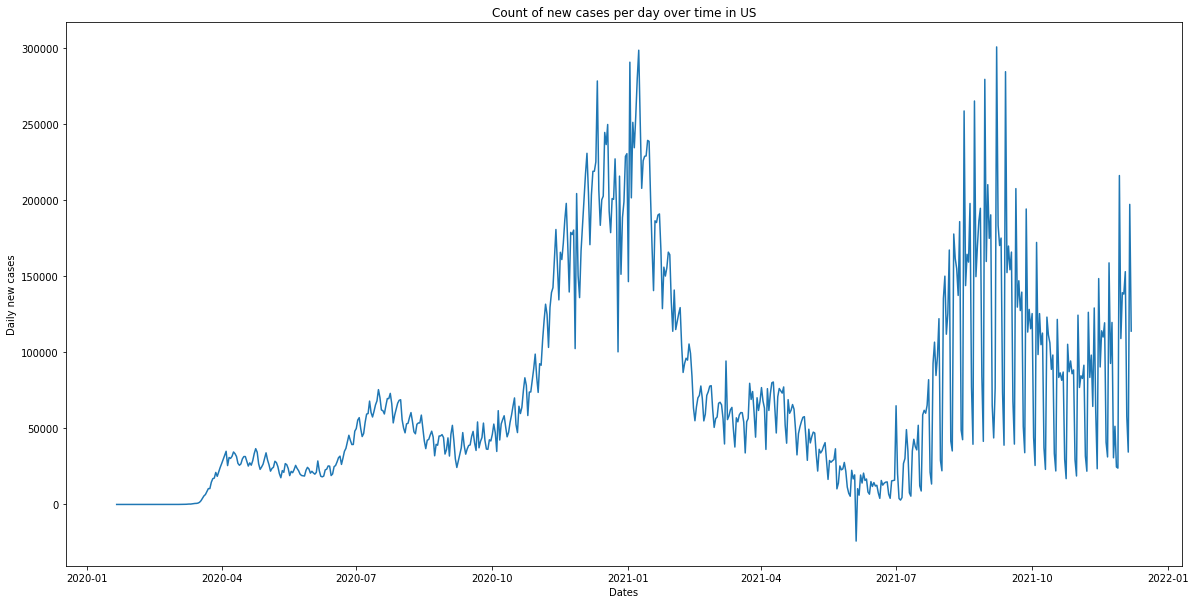

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(df_USdaily['REPORT_DATE'], df_USdaily['PEOPLE_POSITIVE_NEW_CASES_COUNT'])  
plt.ylabel('Daily new cases')
# plt.semilogx()
plt.xlabel('Dates')
plt.title('Count of new cases per day over time in US')
plt.savefig('../figures/USdailyCountvsTime.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



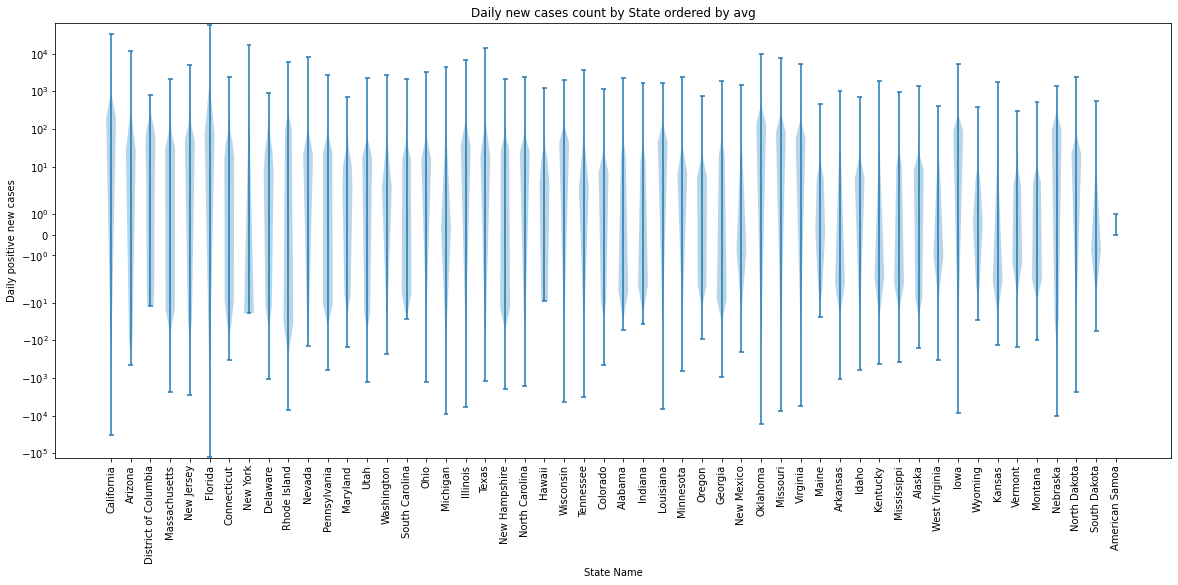

In [40]:
categories = df_us.groupby(['PROVINCE_STATE_NAME'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].agg('mean').reset_index().sort_values(by=['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ascending=False)['PROVINCE_STATE_NAME'].unique()

dataset = [df_us[df_us['PROVINCE_STATE_NAME']==i]['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values for i in categories]

plt.figure(figsize=(20, 8))
plt.violinplot(dataset = dataset)
plt.xticks([i+1 for i in range(len(categories))],categories, rotation = 90)
plt.ylabel('Daily positive new cases')
# plt.semilogy()
plt.yscale('symlog')
plt.xlabel('State Name')
plt.title('Daily new cases count by State ordered by avg')
# plt.savefig('../figures/states-violin.png')
plt.show()

In [ ]:
# https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [ ]:
df_StateCases = df_us.groupby(['PROVINCE_STATE_NAME'])['PEOPLE_POSITIVE_CASES_COUNT'].agg('max').reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=[us_state_to_abbrev[x] for x in df_StateCases['PROVINCE_STATE_NAME']], # Spatial coordinates
    z = df_StateCases['PEOPLE_POSITIVE_CASES_COUNT'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = 'State Max Total COVID-19 Positive Cases',
    geo_scope='usa', # limite map scope to USA
)

fig.write_image("../figures/stateMax.png")
fig.show()

In [ ]:
df_StateCases = df_us.groupby(['PROVINCE_STATE_NAME'])['PEOPLE_POSITIVE_NEW_CASES_COUNT'].agg('mean').reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=[us_state_to_abbrev[x] for x in df_StateCases['PROVINCE_STATE_NAME']], # Spatial coordinates
    z = df_StateCases['PEOPLE_POSITIVE_NEW_CASES_COUNT'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = 'State Mean Daily COVID-19 Positive Cases',
    geo_scope='usa', # limite map scope to USA
)

fig.write_image("../figures/dailyStateMean.png")
fig.show()

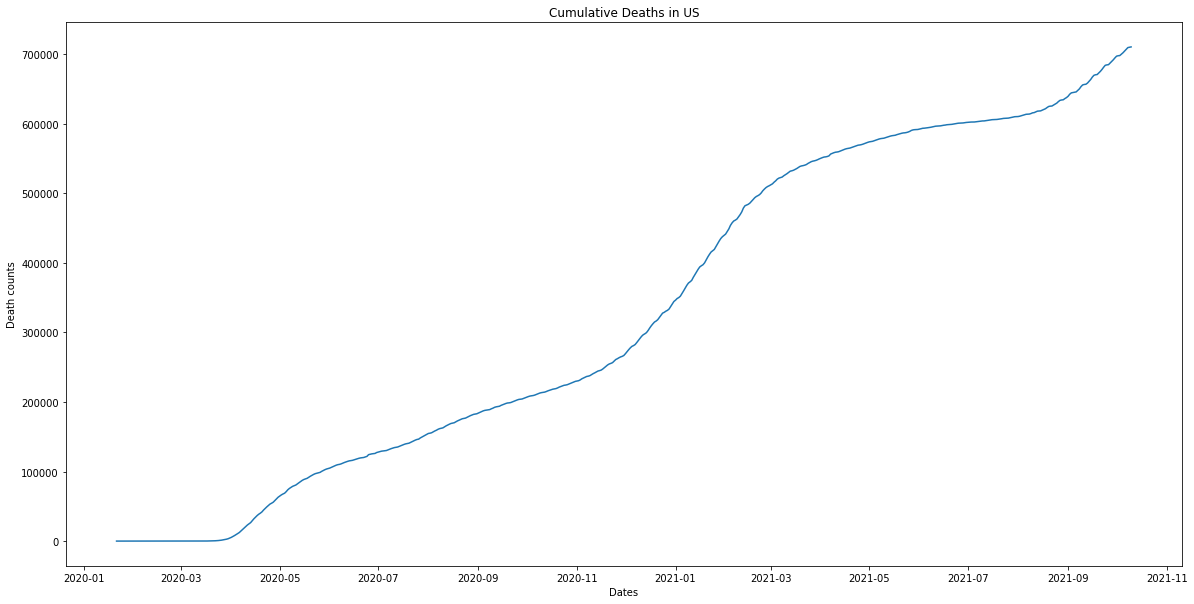

In [ ]:
df2 = df_us[['REPORT_DATE','PEOPLE_DEATH_COUNT']].groupby(by='REPORT_DATE').agg('sum').reset_index()

plt.figure(figsize=(20, 10))
plt.plot(df2['REPORT_DATE'], df2['PEOPLE_DEATH_COUNT'])  
plt.ylabel('Death counts')
# plt.semilogx()
plt.xlabel('Dates')
plt.title('Cumulative Deaths in US')
plt.savefig('../figures/USdeaths.png')
plt.show()

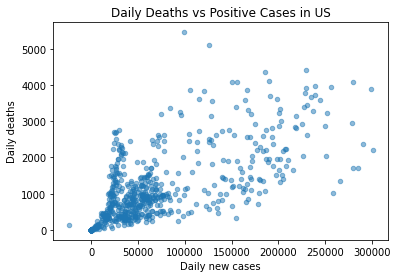

In [ ]:
df2 = df_us[['REPORT_DATE','PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_NEW_COUNT']].groupby(by='REPORT_DATE').agg('sum').reset_index()
df2[['PEOPLE_POSITIVE_NEW_CASES_COUNT','PEOPLE_DEATH_NEW_COUNT']].plot.scatter('PEOPLE_POSITIVE_NEW_CASES_COUNT','PEOPLE_DEATH_NEW_COUNT', alpha=0.5)
plt.xlabel('Daily new cases')
plt.ylabel('Daily deaths')
plt.title('Daily Deaths vs Positive Cases in US')
plt.savefig('../figures/USDeathsvCases.png')
plt.show()

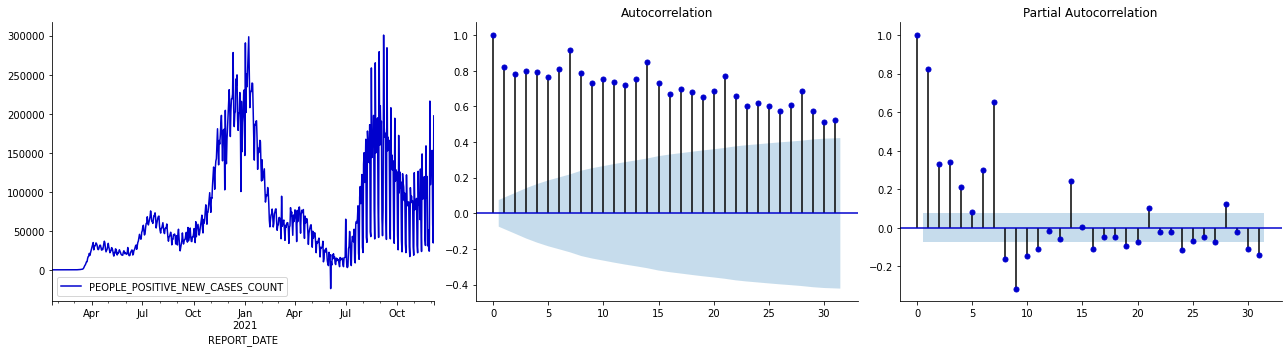

In [ ]:
# https://github.com/mollyliebeskind/sales_forecasting/
import statsmodels.tsa.api as smt

def plots(data, indcol = 'REPORT_DATE', lags=None):
    
  # Convert dataframe to datetime index
  dt_data = data.set_index(indcol)
  
  layout = (1, 3)
  raw  = plt.subplot2grid(layout, (0, 0))
  acf  = plt.subplot2grid(layout, (0, 1))
  pacf = plt.subplot2grid(layout, (0, 2))
  
  dt_data.plot(ax=raw, figsize=(18, 5), color='mediumblue')
  smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
  smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
  sns.despine()
  # plt.savefig('../figures/autocorr.png')
  plt.tight_layout()

plots(df_USdaily, lags=31);

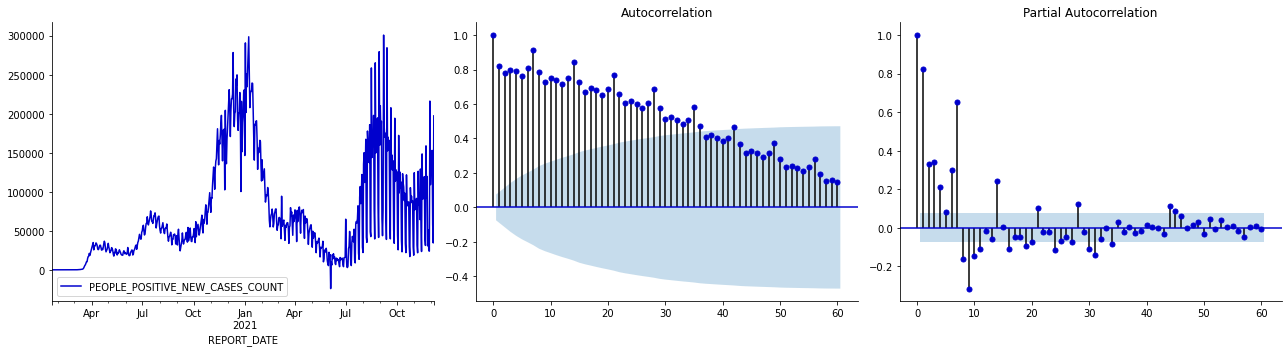

In [ ]:
# https://github.com/mollyliebeskind/sales_forecasting/
import statsmodels.tsa.api as smt

def plots(data, indcol = 'REPORT_DATE', lags=None):
    
  # Convert dataframe to datetime index
  dt_data = data.set_index(indcol)
  
  layout = (1, 3)
  raw  = plt.subplot2grid(layout, (0, 0))
  acf  = plt.subplot2grid(layout, (0, 1))
  pacf = plt.subplot2grid(layout, (0, 2))
  
  dt_data.plot(ax=raw, figsize=(18, 5), color='mediumblue')
  smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
  smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
  sns.despine()
  # plt.savefig('../figures/autocorr.png')
  plt.tight_layout()

plots(df_USdaily, lags=60);

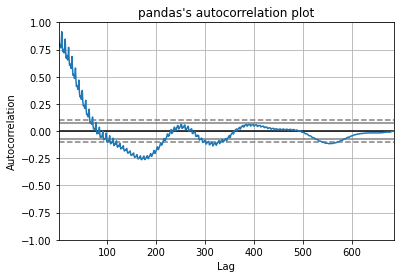

In [ ]:
pd.plotting.autocorrelation_plot(df_USdaily['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
plt.title("pandas's autocorrelation plot")
plt.show()

# Preprocessing

In [11]:
# sklearn.model_selection.TimeSeriesSplit

def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag, 31 lags
    for i in range(1,36):
        col = 'lag_' + str(i)
        supervised_df[col] = supervised_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    # supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df
model_df = generate_supervised(df_USdaily)
model_df

,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35
0,2020-02-25,2,13.0,0.0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0
1,2020-02-26,15,2.0,13.0,0.0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2,2020-02-27,0,15.0,2.0,13.0,0.0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
3,2020-02-28,5,0.0,15.0,2.0,13.0,0.0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
4,2020-02-29,5,5.0,0.0,15.0,2.0,13.0,0.0,0.0,3.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2021-12-03,153024,138289.0,139197.0,109070.0,216215.0,23903.0,24604.0,51383.0,30671.0,119636.0,92702.0,158812.0,31230.0,40839.0,119417.0,110044.0,114150.0,90383.0,148487.0,23466.0,61138.0,129160.0,64436.0,98186.0,83493.0,126316.0,21846.0,31791.0,91526.0,82827.0,84582.0,76901.0,124436.0,18715.0,29291.0,88422.0
648,2021-12-04,57985,153024.0,138289.0,139197.0,109070.0,216215.0,23903.0,24604.0,51383.0,30671.0,119636.0,92702.0,158812.0,31230.0,40839.0,119417.0,110044.0,114150.0,90383.0,148487.0,23466.0,61138.0,129160.0,64436.0,98186.0,83493.0,126316.0,21846.0,31791.0,91526.0,82827.0,84582.0,76901.0,124436.0,18715.0,29291.0
649,2021-12-05,34417,57985.0,153024.0,138289.0,139197.0,109070.0,216215.0,23903.0,24604.0,51383.0,30671.0,119636.0,92702.0,158812.0,31230.0,40839.0,119417.0,110044.0,114150.0,90383.0,148487.0,23466.0,61138.0,129160.0,64436.0,98186.0,83493.0,126316.0,21846.0,31791.0,91526.0,82827.0,84582.0,76901.0,124436.0,18715.0
650,2021-12-06,197258,34417.0,57985.0,153024.0,138289.0,139197.0,109070.0,216215.0,23903.0,24604.0,51383.0,30671.0,119636.0,92702.0,158812.0,31230.0,40839.0,119417.0,110044.0,114150.0,90383.0,148487.0,23466.0,61138.0,129160.0,64436.0,98186.0,83493.0,126316.0,21846.0,31791.0,91526.0,82827.0,84582.0,76901.0,124436.0


In [ ]:
from sklearn.model_selection import train_test_split

def basic_split(X, y, train_size = 0.6, val_size = 0.2, test_size = 0.2, random_seed = 42):
    if type(random_seed)!= int:
        raise ValueError("Random_seed should be an integer.")
    if (train_size+val_size+test_size) != 1:
        raise ValueError("The sum of train_size, val_size, test_size should be 1.")

    random_state = random_seed

    if val_size == 0:
      X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = train_size, random_state=random_state)
      X_val, y_val = None, None
    else:
      # first split to separate out the training set
      X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = train_size,random_state=random_state)
      # second split to separate out the validation and test sets
      X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = (val_size/(1-train_size)),random_state=random_state)
    
    allsize = X.shape[0]
    # if ((round(X_train.shape[0]/allsize, 1) != 0.6) or 
    #     (round(X_val.shape[0]/allsize, 1) != val_siz3) or 
    #     (round(X_test.shape[0]/allsize, 1) != test_size)):
    #     raise ValueError("Data not split into desired size.")

    return X_train, y_train, X_val, y_val, X_test, y_test

# let's separate the feature matrix X, and target variable y
X = model_df.iloc[:, 2:]
y = model_df['PEOPLE_POSITIVE_NEW_CASES_COUNT']
X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, train_size = 0.6, val_size = 0, test_size = 0.4, random_seed = 13)
print(X_train.head())
# print(X_val.head())
print(X_test.head())

       lag_1    lag_2    lag_3    lag_4  ...   lag_27   lag_28   lag_29   lag_30
400  69031.0  79646.0  56516.0  54417.0  ...  62479.0  78072.0  77768.0  74115.0
167  52985.0  47076.0  50254.0  55717.0  ...  59761.0  59398.0  53947.0  46630.0
78   28411.0  24461.0  23660.0  21893.0  ...  31553.0  33395.0  34499.0  31634.0
197  46130.0  31814.0  43770.0  36023.0  ...  54500.0  60385.0  57201.0  53344.0
90   20882.0  21763.0  18957.0  23610.0  ...  33393.0  28772.0  25810.0  27352.0

[5 rows x 30 columns]
       lag_1    lag_2    lag_3    lag_4  ...   lag_27   lag_28   lag_29   lag_30
99   22422.0  18670.0  18828.0  19029.0  ...  29290.0  33934.0  30284.0  26486.0
430  49400.0  62610.0  65685.0  61927.0  ...  70140.0  44238.0  60287.0  74226.0
98   18670.0  18828.0  19029.0  19941.0  ...  33934.0  30284.0  26486.0  24637.0
233  58309.0  55788.0  52935.0  42366.0  ...  33055.0  38573.0  47248.0  37197.0
37   17309.0  16968.0  14622.0  10422.0  ...     18.0      5.0      5.0      0.0

[5 r

In [ ]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
# X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.transform(X_test)

print('X_train transformed - show first')
print(X_train_ss[0])
# print('\nX_val transformed - show first')
# print(X_val_ss[0])
print('\nX_test transformed - show first')
print(X_test_ss[0])

# Regression models tried on dataset

## Compare R2 in train-test split and Time Series split:

In [ ]:
r2s = []
for randstates in range(30):
  X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, train_size = 0.8, val_size = 0, test_size = 0.2, random_seed = 3*randstates)

  scaler = StandardScaler()
  X_train_ss = scaler.fit_transform(X_train)
  # X_val_ss = scaler.transform(X_val)
  X_test_ss = scaler.transform(X_test)

  mod = LinearRegression()
  mod.fit(X_train_ss, y_train)
  pred = mod.predict(X_test_ss)
  len(pred)
  r2 = r2_score(y_test, pred)
  r2s.append(r2)

r2s = np.array(r2s)

print(r2s)
print(r2s.mean(), r2s.std())

[0.82959332 0.8265366  0.84332286 0.8831251  0.8629165  0.85530813
 0.80343482 0.82190575 0.89454153 0.82491088 0.91909813 0.79362574
 0.84439391 0.83208198 0.90876649 0.84645988 0.89481435 0.91230814
 0.78689407 0.86732741 0.89525213 0.89260327 0.92775369 0.90611387
 0.82619752 0.90053859 0.93694021 0.83789021 0.88204765 0.88909502]
0.8648599257440903 0.04067484988808678


In [ ]:
r2s.mean()- 2*r2s.std()

0.8105735721623581

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
mod = LinearRegression()
mod.fit(X_train_ss, y_train)
pred = mod.predict(X_test_ss)
len(pred)
# # df_pred = df_USdaily.copy()
# df_pred = df_USdaily.iloc[300:]
# df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-21)), pred)
# df_pred

260

In [ ]:
X_train_ss.shape

(388, 30)

In [ ]:
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

MSE: 513933942.8193606
MAE: 11917.372041265771
R2 Score: 0.8889994768892633


In [15]:
from sklearn.model_selection import TimeSeriesSplit

X = model_df.iloc[:, 2:]
y = model_df['PEOPLE_POSITIVE_NEW_CASES_COUNT']

test_size= int(0.2 * len(y))

tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)  # test on 21 days of data
for train_index, test_index in tscv.split(X):
  pass
print(len(train_index), len(test_index))
# print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
# X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.transform(X_test)

# transform target?

522 130


## Baseline Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



MSE: 3606233531.0445786
MAE: 47957.16445012787
R2 Score: -0.0007912172654329641


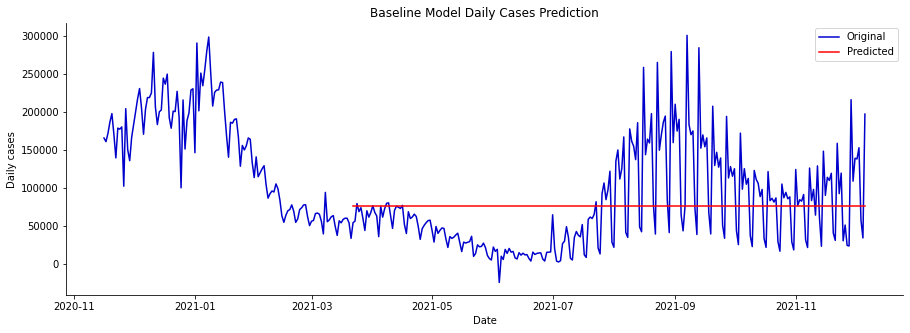

In [ ]:
df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-test_size)), np.repeat(y_train.mean(), test_size))

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Baseline Model Daily Cases Prediction")
ax.legend()
sns.despine()

mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

## Other Models

In [25]:
from joblib import dump, load
from sklearn.pipeline import make_pipeline

def MLpipe_CV_R2(X, y, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    test_size= int(0.2 * len(y))
    tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)  # test on 21 days of data
    for train_index, test_index in tscv.split(X):
      pass
    X_other, X_test = X.iloc[train_index], X.iloc[test_index]
    y_other, y_test = y.iloc[train_index], y.iloc[test_index]

    # splitter for other
    ts = int(0.25 * len(y_other))
    print(test_size, ts)
    kf = TimeSeriesSplit(n_splits=3, test_size=ts)  # test on 21 days of data
    clf = ML_algo
    pipe = make_pipeline(StandardScaler(),clf)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'r2',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True, error_score = 'raise')

    # this line actually fits the model on other
    grid.fit(X_other, y_other)
    # save results into a data frame. feel free to print it and inspect it
    results = pd.DataFrame(grid.cv_results_)
    print('Best mean score: ', results['mean_test_score'].max())
    print('Associated score std: ', results['std_test_score'][results['mean_test_score'].argmax()])
    # print(results)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    
    dump(grid, f'{str(ML_algo)}.joblib')
    # calculate and save the test score
    y_test_pred = grid.predict(X_test)       
    test_scores = r2_score(y_test,y_test_pred)
    
    return results, test_scores

In [26]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
param_grid = {'lasso__alpha': np.logspace(-6,8,41)}

_, Lasso_score = MLpipe_CV_R2(X, y, ML_algo = Lasso(random_state=13, max_iter=1e5), param_grid = param_grid)
Lasso_score

130 130
Fitting 3 folds for each of 41 candidates, totalling 123 fits
Best mean score:  0.8362710519746054
Associated score std:  0.050759482062015235
best model parameters: {'lasso__alpha': 112.20184543019607}
validation score: 0.8362710519746054


0.5769322689894529

In [28]:
param_grid = {'ridge__alpha': np.logspace(-6,12,41)}
_, Ridge_scores = MLpipe_CV_R2(X, y, ML_algo = sklearn.linear_model.Ridge(random_state=13, max_iter=1e5), param_grid = param_grid)
Ridge_scores

130 130
Fitting 3 folds for each of 41 candidates, totalling 123 fits
Best mean score:  0.8427270299801238
Associated score std:  0.061854387362147996
best model parameters: {'ridge__alpha': 5.623413251903491}
validation score: 0.8427270299801238


0.5679202270867101

In [29]:
param_grid = {
              'elasticnet__alpha': np.logspace(-6,8,41),
              'elasticnet__l1_ratio': np.linspace(0, 1, 21),
              }

_, EN_scores = MLpipe_CV_R2(X, y, ML_algo = sklearn.linear_model.ElasticNet(random_state=13, max_iter=1e5), param_grid = param_grid)
EN_scores

130 130
Fitting 3 folds for each of 861 candidates, totalling 2583 fits
Best mean score:  0.8435364169605974
Associated score std:  0.06597429428309284
best model parameters: {'elasticnet__alpha': 0.03548133892335753, 'elasticnet__l1_ratio': 0.45}
validation score: 0.8435364169605974


0.557197096912383

In [32]:
param_grid = {'randomforestregressor__n_estimators': [100, 120, 150, 300, 500],
              'randomforestregressor__max_depth': [1, 3, 5, 7, 8, 9, 10, 30]
              }

_, RF_scores = MLpipe_CV_R2(X, y, ML_algo = sklearn.ensemble.RandomForestRegressor(random_state = 13), param_grid = param_grid)
RF_scores

130 130
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best mean score:  0.39399298643724795
Associated score std:  0.3203162858097404
best model parameters: {'randomforestregressor__max_depth': 9, 'randomforestregressor__n_estimators': 120}
validation score: 0.39399298643724795


0.0693643178847485

In [ ]:
param_grid = {'fit_intercept': [True, False]}

_, LR_scores = MLpipe_CV_R2(X, y, ML_algo = LinearRegression(), param_grid = param_grid)
LR_scores

130 130
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best mean score:  0.806398088557259
Associated score std:  0.0782376771065156
best model parameters: {'fit_intercept': True}
validation score: 0.806398088557259


0.5647778634329648

In [ ]:
param_grid = {
    'gamma': np.logspace(-6,3,21),
    'C': np.logspace(-6,3,21)}

_, SVR_scores = MLpipe_CV_R2(X, y, ML_algo = sklearn.svm.SVR(max_iter = 1e5), param_grid = param_grid)

130 130
Fitting 3 folds for each of 441 candidates, totalling 1323 fits
Best mean score:  -1.7794027799721317
Associated score std:  1.0451343491137193
best model parameters: {'C': 1e-06, 'gamma': 1e-06}
validation score: -1.7794027799721317


In [33]:
# Various hyper-parameters to tune
param_grid = {
              'xgbregressor__learning_rate': np.logspace(-6,0,5), #so called `eta` value
              'xgbregressor__max_depth': np.linspace(0, 100, 5, dtype= np.int),
              'xgbregressor__n_estimators': np.linspace(1, 500, 5, dtype= np.int)}

_, XGB_scores = MLpipe_CV_R2(X, y, ML_algo = XGBRegressor(), param_grid = param_grid)
XGB_scores

130 130
Fitting 3 folds for each of 125 candidates, totalling 375 fits
[09:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best mean score:  0.44943325394692407
Associated score std:  0.2917489551229562
best model parameters: {'xgbregressor__learning_rate': 0.03162277660168379, 'xgbregressor__max_depth': 25, 'xgbregressor__n_estimators': 500}
validation score: 0.44943325394692407


0.19246618906763624

522 130
MSE: 1678201460.3234732
MAE: 27645.289808445476
R2 Score: 0.5770143228031146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



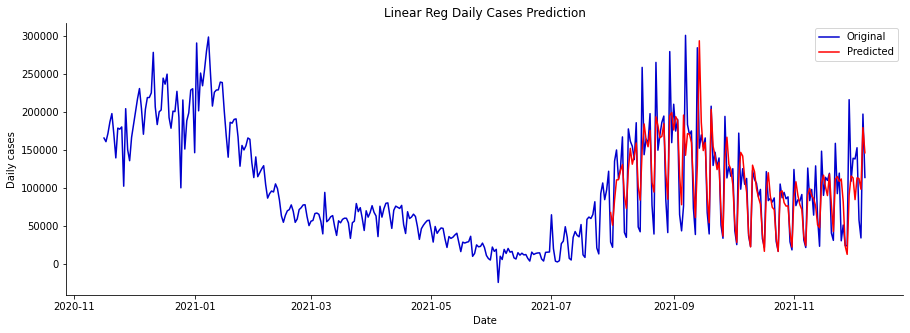

In [31]:
X = model_df.iloc[:, 2:]
y = model_df['PEOPLE_POSITIVE_NEW_CASES_COUNT']

test_size= int(0.2 * len(y))

tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)  # test on 21 days of data
for train_index, test_index in tscv.split(X):
  pass
print(len(train_index), len(test_index))
# print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# scaler = StandardScaler()
# X_train_ss = scaler.fit_transform(X_train)
# X_test_ss = scaler.transform(X_test)

mod = Lasso(alpha = 3981071.7055349695, random_state=13, max_iter=1e5)
mod.fit(X_train, y_train)
pred = mod.predict(X_test)

df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-test_size)), pred)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Linear Reg Daily Cases Prediction")
ax.legend()
sns.despine()

mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.savefig('LinRegPred.png')

In [ ]:
mod = LinearRegression()
mod.fit(X_train_ss, y_train)
pred = mod.predict(X_test_ss)
len(pred)

130

In [ ]:
# df_pred = df_USdaily.copy()
df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-test_size)), pred)
df_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,REPORT_DATE,PEOPLE_POSITIVE_NEW_CASES_COUNT,pred
300,2020-11-16,165773,NaN
301,2020-11-17,160986,NaN
302,2020-11-18,171830,NaN
303,2020-11-19,186911,NaN
304,2020-11-20,197906,NaN
...,...,...,...
681,2021-12-02,138289,82460.177867
682,2021-12-03,153024,118023.031474
683,2021-12-04,57985,116537.859594
684,2021-12-05,34417,102396.517195


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



MSE: 1727183762.8568275
MAE: 27673.564494256163
R2 Score: 0.564777863432965


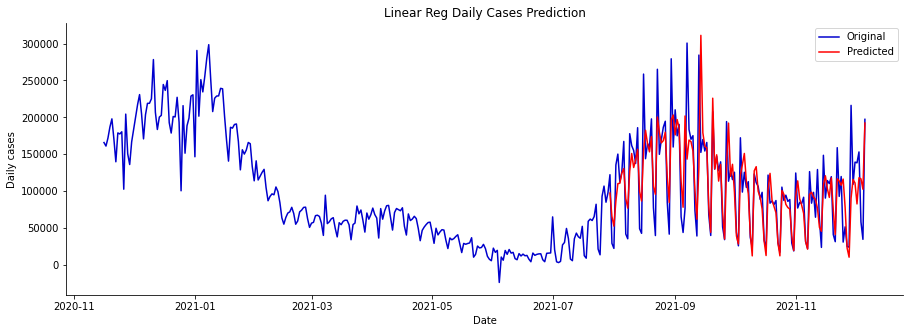

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Linear Reg Daily Cases Prediction")
ax.legend()
sns.despine()

mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.savefig('LinRegPred.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



MSE: 959684655.3788642
MAE: 18768.492079322332
R2 Score: 0.7187446543538285


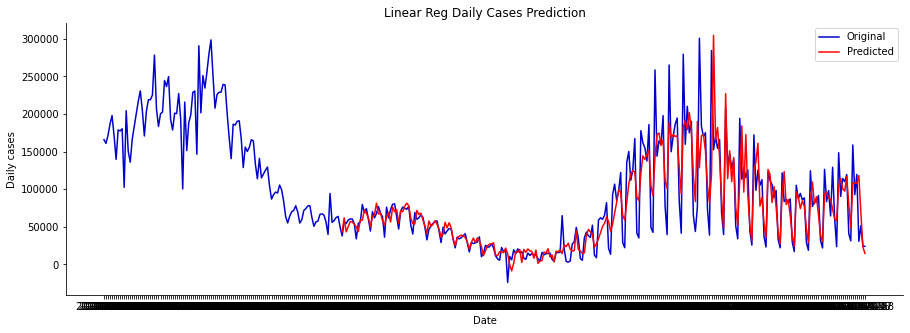

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="Linear Reg Daily Cases Prediction")
ax.legend()
sns.despine()

mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

# plt.savefig('LinRegPred.png')

In [34]:
clf = load('Lasso(max_iter=100000.0, random_state=13).joblib') 

[21:16:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



MSE: 3180258298.2606597
MAE: 39754.744486177886
R2 Score: 0.19862678125536448


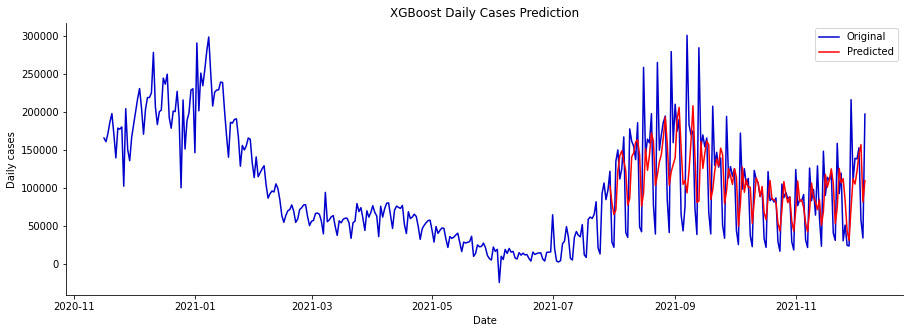

In [ ]:
mod = XGBRegressor(n_estimators=100, learning_rate=0.2)
mod.fit(X_train, y_train)
pred = mod.predict(X_test)
df_pred = df_USdaily.iloc[300:]
df_pred['pred'] = np.append(np.repeat(np.nan, (df_pred.shape[0]-test_size)), pred)
df_pred
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(df_pred.REPORT_DATE, df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT, data=df_pred, ax=ax,
              label='Original', color='mediumblue')
sns.lineplot(df_pred.REPORT_DATE, df_pred.pred, data=df_pred, ax=ax,
              label='Predicted', color='red')
ax.set(xlabel="Date",
        ylabel="Daily cases",
        title="XGBoost Daily Cases Prediction")
ax.legend()
sns.despine()


mse = mean_squared_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
mae = mean_absolute_error(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])
r2 = r2_score(df_pred.PEOPLE_POSITIVE_NEW_CASES_COUNT[-test_size:], df_pred.pred[-test_size:])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

# plt.savefig('../figures/XGBPred.png')

In [ ]:
# !pip install auto_ts --upgrade
# datetime_df = df_USdaily.set_index('REPORT_DATE')

## Feature Importance

[ 16970.27400741  16849.24290892  11441.64403318  11301.85150149
   4589.49627591   4912.95133897  28214.63541696 -13356.03918278
 -14616.76003655  -7331.15864267  -7220.06869477    377.0388685
   3660.14341589  -4091.20415078   9187.50996517   -159.42249924
   6479.91386424    983.84826527  -2155.36868094  -1356.76835166
   5236.569503    -5244.22678384  -1399.92371127  -3981.62193542
    197.60517034   3269.90123918    354.97097551  10309.14570057
   8998.44425541  -7070.32302038  -7665.24698775  -6067.33687551
  -3535.56934325   -199.18468972   2623.65123281]


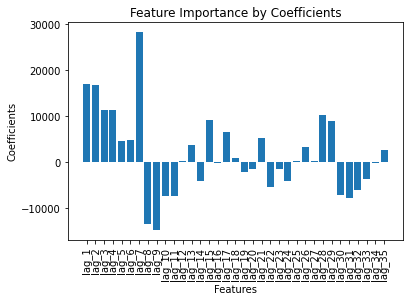

In [ ]:
mod = LinearRegression()
mod.fit(X_train_ss, y_train)
pred = mod.predict(X_test_ss)
len(pred)
print(mod.coef_)
# bar plot
plt.bar(model_df.columns[2:], mod.coef_)
plt.ylabel('Coefficients')
# plt.semilogy()
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.title('Feature Importance by Coefficients')
plt.savefig('../figures/GlobalFeatImportance.png')
plt.show()

In [ ]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
regressor = RandomForestRegressor(n_estimators=80, max_depth = 8)
# Fit our model.
model = regressor.fit(X_train_ss, y_train)
explainer = shap.TreeExplainer(model)

print(np.shape(X_test_ss))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_ss)
print(np.shape(shap_values))

(130, 35)
(130, 35)


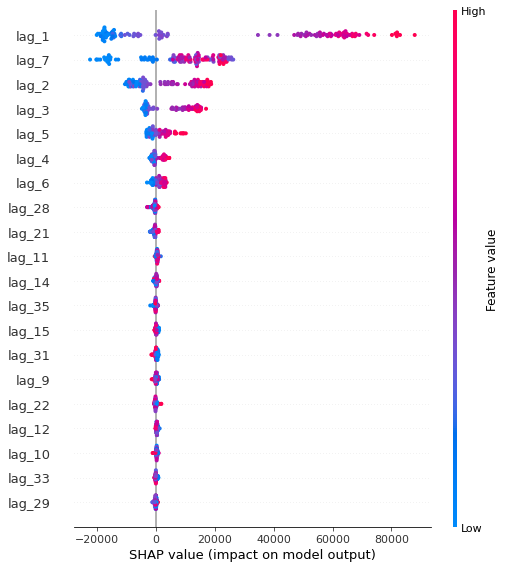

In [ ]:
shap.summary_plot(shap_values, X_test_ss,feature_names = model_df.columns[2:])

In [ ]:
X_test_ss.shape

(130, 35)

In [ ]:
shap_values[1].shape

(35,)

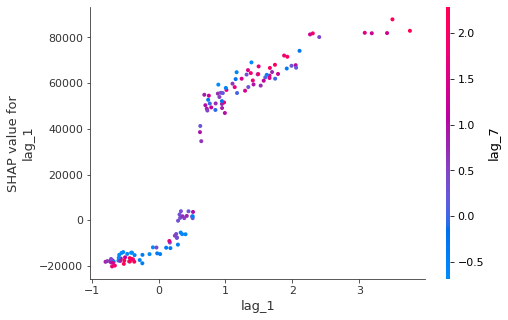

In [ ]:
shap.dependence_plot(0, shap_values, X_test_ss, feature_names=model_df.columns[2:])

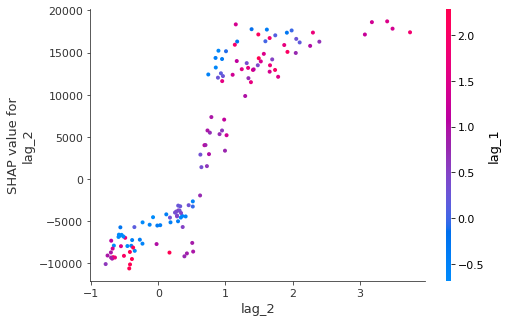

In [ ]:
shap.dependence_plot(1, shap_values, X_test_ss, feature_names=model_df.columns[2:])

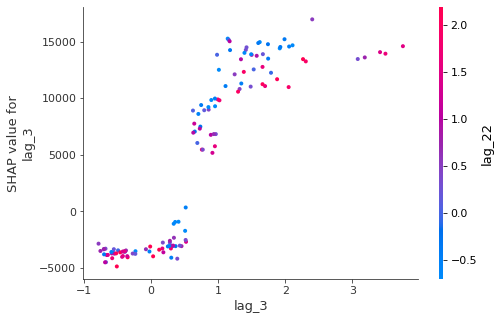

In [ ]:
shap.dependence_plot(2, shap_values, X_test_ss, feature_names=model_df.columns[2:])

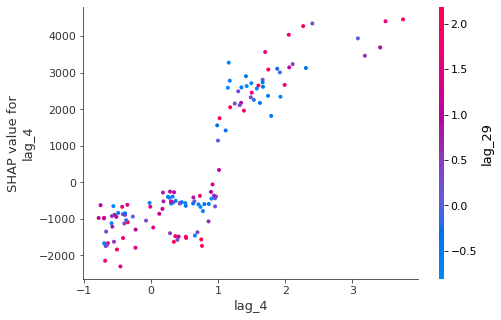

In [ ]:
shap.dependence_plot(3, shap_values, X_test_ss, feature_names=model_df.columns[2:])

In [ ]:
import pickle

np.random.seed(42)
ftr_names = model_df.columns[2:]
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = clf.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(clf.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.5764186389021209
test baseline =  0.0
shuffling lag_1
   shuffled test score: 0.54 +/- 0.032
shuffling lag_2
   shuffled test score: 0.507 +/- 0.034
shuffling lag_3
   shuffled test score: 0.517 +/- 0.018
shuffling lag_4
   shuffled test score: 0.552 +/- 0.018
shuffling lag_5
   shuffled test score: 0.586 +/- 0.007
shuffling lag_6
   shuffled test score: 0.567 +/- 0.005
shuffling lag_7
   shuffled test score: 0.137 +/- 0.053
shuffling lag_8
   shuffled test score: 0.483 +/- 0.025
shuffling lag_9
   shuffled test score: 0.473 +/- 0.022
shuffling lag_10
   shuffled test score: 0.567 +/- 0.009
shuffling lag_11
   shuffled test score: 0.562 +/- 0.009
shuffling lag_12
   shuffled test score: 0.576 +/- 0.0
shuffling lag_13
   shuffled test score: 0.579 +/- 0.003
shuffling lag_14
   shuffled test score: 0.58 +/- 0.001
shuffling lag_15
   shuffled test score: 0.587 +/- 0.008
shuffling lag_16
   shuffled test score: 0.575 +/- 0.001
shuffling lag_17
   shuffled test score: 0.571 

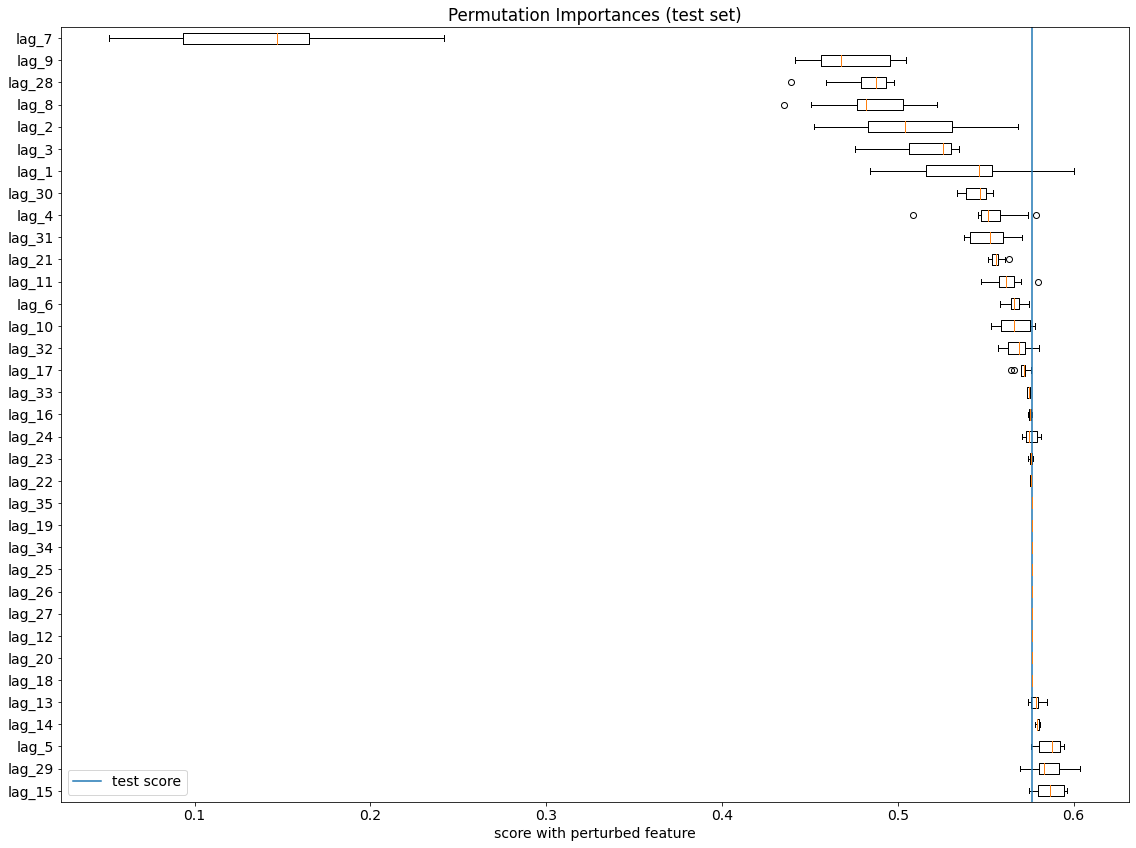

In [ ]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(16,12))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

# Future work
* Change number of lags based on coefficients
* 用time series吧，最开始的data几乎是0,和后面区别很大(两种shuffle的R2分数区别的原因)